In [2]:
import numpy as np

##Import mask
mask5=np.load('C:/Users/David Brown/Documents/Huang Lab/Exp0104_KDM5A_PHD2-fragments/Output/Well03_HeLa_PHD2-IDR-PHD3[W1625A]_3_Mask5.npy')

In [3]:
import time

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

z=4

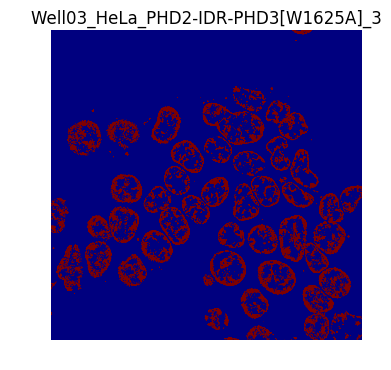

In [5]:
##Check the mask
plt.imshow(mask5[z])
plt.axis('off')
plt.title('Well03_HeLa_PHD2-IDR-PHD3[W1625A]_3')

In [6]:
def labelNuceli(mask, min_vol = 8000):
#By default min_vol = 8000

    import mahotas as mh
    from skimage import morphology
    
    labeled_mask, nr_objects=mh.label(mask)
    print('{} objects were detected.'.format(nr_objects))
    
    real=morphology.remove_small_objects(labeled_mask, min_vol)
    
    #Reset counts  and count the labels, 
    relabeled, n_left = mh.labeled.relabel(real)
    print('After filtering and relabeling, there are {} nuclei left.'.format(n_left))

    return relabeled

In [7]:
relabeled=labelNuceli(mask5)

346629 objects were detected.
After filtering and relabeling, there are 41 nuclei left.


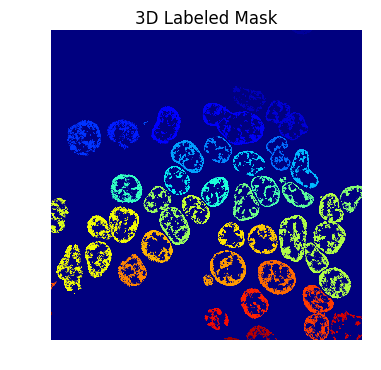

In [8]:
plt.imshow(relabeled[z])
plt.axis('off')
plt.title('3D Labeled Mask')

In [9]:
#Give opencv another go
import cv2

img8 = (relabeled[z]).astype('uint8')
image, contours, hierarchy = cv2.findContours(img8, 1, 2)

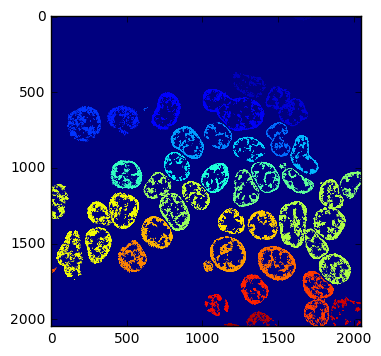

In [10]:
plt.imshow(img8)

In [11]:
cnt = contours[7]
M = cv2.moments(cnt)
cnt

array([[[1729, 2046]],

       [[1730, 2045]],

       [[1732, 2045]],

       [[1733, 2046]],

       [[1732, 2047]],

       [[1730, 2047]]])

In [25]:
len(contours)

35760

In [12]:
#Approximate contours for an individual
epsilon = 0.1*cv2.arcLength(cnt,True)
approx = cv2.approxPolyDP(cnt,epsilon,True)

In [28]:
epsilon

[0.0]

In [13]:
approx

array([[[1729, 2046]],

       [[1730, 2045]],

       [[1733, 2046]],

       [[1732, 2047]]])

Step #2 - Reshape to 2D matrices

The contours themselves get stored as a list of NumPy arrays. 
For the simple image provided, there should only be one contour detected, so extract out the first element of the list, then use numpy.reshape to reshape the 3D matrices into their 2D forms where each row is a (x, y) point.

In [20]:
np.reshape(approx, (-1,2))

array([[1729, 2046],
       [1730, 2045],
       [1733, 2046],
       [1732, 2047]])

In [21]:
##Convert approx back to a binary image
test=np.zeros_like(img8)
test[approx]=1

In [31]:
test=cv2.drawContours(np.zeros_like(img8), [cnt], 0, (0,255,0), 3)

In [22]:
test.nonzero()

(array([1729, 1729, 1729, ..., 2047, 2047, 2047], dtype=int64),
 array([   0,    1,    2, ..., 2045, 2046, 2047], dtype=int64))

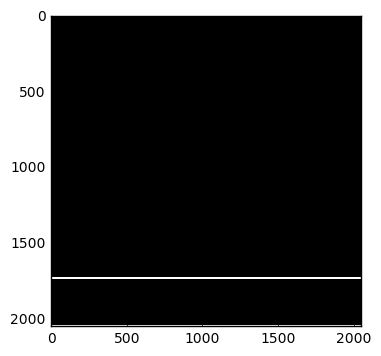

In [23]:
from skimage import morphology
plt.imshow(morphology.binary_dilation(test, np.ones((9,9))), cmap='gray')

In [40]:
from skimage import img_as_float

test=img_as_float(img)

ValueError: can not convert object to float64.

TypeError: Image data can not convert to float

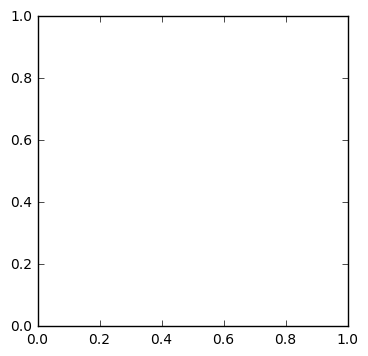

In [39]:
plt.imshow(img)
plt.axis('off')
plt.title('3D Labeled Mask')

In [46]:
##Define the Object Hulls (~20minutes) 
def hull_3D(labeled_mask):
    
    from skimage.morphology import convex_hull_image
    from mahotas.labeled import filter_labeled
    
    #Let's do every z slice
    filled_mask=np.zeros_like(labeled_mask)
    for z, frame in enumerate(labeled_mask):
        print(z)
        #Could remove on boarders at this point?
        final=np.zeros_like(frame)

        for l in range(frame.max()):
            ll=l+1
            hull = convex_hull_image(frame==ll)*ll
            final = final + hull

        #filled_mask[z]=final #select line to keep objects on the border
        filled_mask[z], n_hulls = filter_labeled(final, remove_bordering=True)
    return filled_mask

In [47]:
##Time conversion on a labeled stack to labeled convex hulls
t0 = time.time() #remember the brackets
hulls = hull_3D(relabeled)
t1 = time.time() #remember the brackets
dt=t1-t0
print (dt)
#~20 minutes

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
1102.50500011


(<matplotlib.axes._subplots.AxesSubplot at 0x147a0cf8>,
 <matplotlib.text.Text at 0x1d96cc88>)

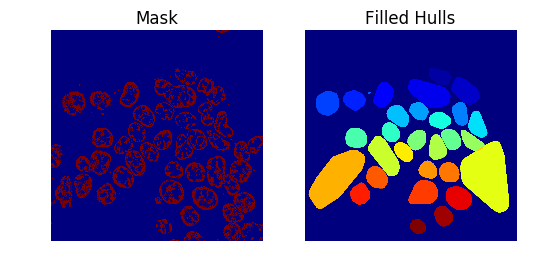

In [48]:
##Compare
plt.subplot(1,2,1),plt.imshow(mask5[z])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Mask')
plt.subplot(1,2,2),plt.imshow(hulls[z])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Filled Hulls')

In [72]:
##Skimage and Mahotas both have modules called 'morphology' and it is a real pain
from skimage import morphology
labeled_mask=hulls
big = morphology.remove_small_objects(labeled_mask, 1250000)
small = labeled_mask-big

(<matplotlib.axes._subplots.AxesSubplot at 0xa9687b00>,
 <matplotlib.text.Text at 0xa9a4de80>)

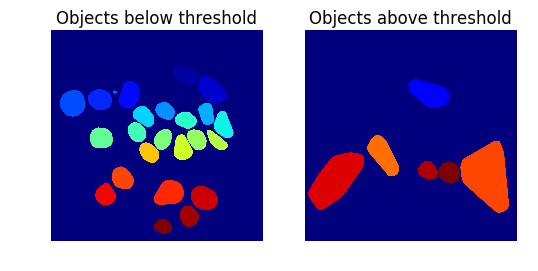

In [75]:
##Compare
plt.subplot(1,2,1),plt.imshow(small[z])
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Objects below threshold')
plt.subplot(1,2,2),plt.imshow(big[z])
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Objects above threshold')

In [89]:
##Calculate 3D distance transform
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

# Calculate distance transform of labeled image
# distance = ndimage.distance_transform_edt(big)

big_binary = (big != 0)

#Calculate distance transform of binary image
distance = ndimage.distance_transform_edt(big_binary)

In [1]:
plt.imshow(big_binary, cmap='gray')
plt.axis('off')
plt.title('Objects above threshold')

NameError: name 'plt' is not defined

In [83]:
#Detect object centers based on distance image
local_max = peak_local_max(distance, indices=False, threshold_abs=5, footprint=np.ones((1, 200, 200)), labels=big)
centers, n_centers = mh.label(local_max)

(<matplotlib.axes._subplots.AxesSubplot at 0xad4b4898>,
 <matplotlib.text.Text at 0xad58cdd8>)

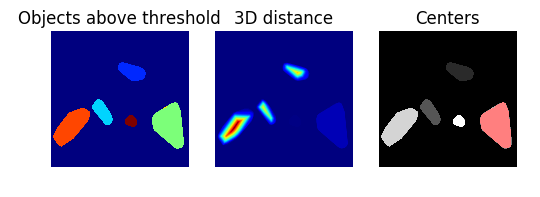

In [84]:
##Compare distance vs 3D distance transform
plt.subplot(1,3,1),plt.imshow(big[z])
plt.subplot(1,3,1),plt.axis('off')
plt.subplot(1,3,1),plt.title('Objects above threshold')
plt.subplot(1,3,2),plt.imshow(distance[z])
plt.subplot(1,3,2),plt.axis('off')
plt.subplot(1,3,2),plt.title('3D distance')
plt.subplot(1,3,3),plt.imshow(mh.overlay(big[z], morphology.binary_dilation(centers[z], np.ones((9,9)))))
plt.subplot(1,3,3),plt.axis('off')
plt.subplot(1,3,3),plt.title('Centers')

In [86]:
#Test 3D watershed in 2D
ws2 = watershed(-distance[z], centers[z], mask=big[z])

In [81]:
#3D watershed
def watershed3D(binary_stack):

    ws3D = np.zeros_like(binary_stack)

    for z, frame in enumerate(binary_stack):
        print(z)
        ws3D[z] = watershed(-distance[z], centers[z], mask=binary_stack[z])
    return ws3D

In [ ]:
##Time conversion on a labeled stack to labeled convex hulls
t0 = time.time() #remember the brackets
ws3 = watershed3D(big)
t1 = time.time() #remember the brackets
dt=t1-t0
print (dt)
#~20 minutes

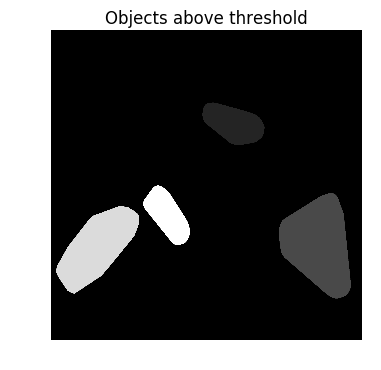

In [88]:
plt.imshow(ws2, cmap='gray')
plt.axis('off')
plt.title('Objects above threshold')

In [76]:
#local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((1, 3, 3)), labels=mask6)
local_max1 = peak_local_max(distance_z4, indices=False)
local_max2 = peak_local_max(distance_z4, indices=False, labels=mask6[4])
local_max3 = peak_local_max(distance_z4, indices=False, threshold_abs=3, labels=mask6[4])
local_max4 = peak_local_max(distance_z4, indices=False, threshold_abs=3, footprint=np.ones((4, 4)), labels=mask6[4])

In [94]:
#local_max5 = peak_local_max(distance_z4, indices=False, threshold_abs=3, footprint=np.ones((50, 50)), labels=mask6[4]) #50,50 works
local_max6 = peak_local_max(distance_z4, indices=False, threshold_abs=3, footprint=np.ones((75, 75)), labels=mask6[4]) #50,50 works

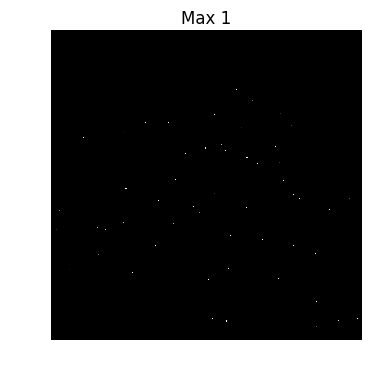

In [88]:
plt.imshow(morphology.binary_dilation(local_max5, np.ones((5,5))), cmap='gray')
plt.axis('off')
plt.title('Max 1')

(<matplotlib.axes._subplots.AxesSubplot at 0x17527d438>,
 <matplotlib.text.Text at 0x119701390>)

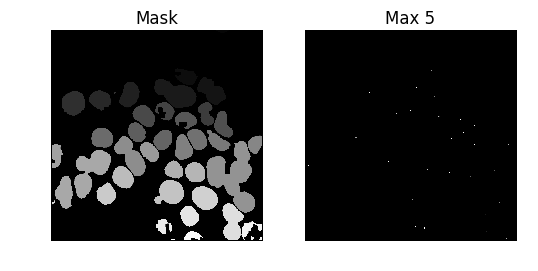

In [91]:
##Compare distance vs 3D distance transform
plt.subplot(1,2,1),plt.imshow(mask6[z], cmap='gray')
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Mask')
plt.subplot(1,2,2),plt.imshow(morphology.binary_dilation(local_max5, np.ones((5,5))), cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Max 5')
# plt.subplot(1,4,3),plt.imshow(local_max3, cmap='gray')
# plt.subplot(1,4,3),plt.axis('off')
# plt.subplot(1,4,3),plt.title('Max 3')
# plt.subplot(1,4,4),plt.imshow(local_max4, cmap='gray')
# plt.subplot(1,4,4),plt.axis('off')
# plt.subplot(1,4,4),plt.title('Max 4')

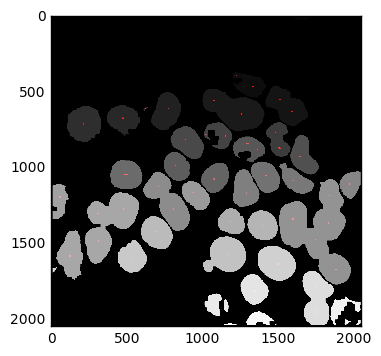

In [95]:
##Check local max using overlay
plt.imshow(mh.overlay(mask6[z], morphology.binary_dilation(local_max6, np.ones((9,9)))))

In [100]:
#Test 2D watershed
markers, n_max = mh.label(local_max6)
labels_ws = watershed(-distance_z4, markers, mask=mask6[z])

(<matplotlib.axes._subplots.AxesSubplot at 0x111ce7fd0>,
 <matplotlib.text.Text at 0x1840df048>)

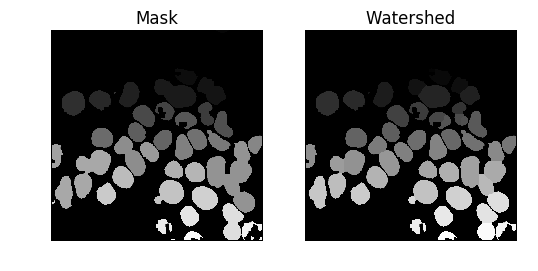

In [101]:
plt.subplot(1,2,1),plt.imshow(mask6[z], cmap='gray')
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Mask')
plt.subplot(1,2,2),plt.imshow(labels_ws, cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Watershed')

##Watershed did improve 2D but may split some nuclei

In [103]:
##What about in 3D?
#Detect 2D maxima in a single plane of the 3D distance image
local_max7 = peak_local_max(distance3D[4], indices=False, threshold_abs=3, labels=mask6[4])

#Detect maxima in 3D space
local_max8 = peak_local_max(distance3D, indices=False, threshold_abs=3, labels=mask6)

In [108]:
#Now try the improved 2D settings
local_max9 = peak_local_max(distance3D, indices=False, threshold_abs=3, footprint=np.ones((1, 75, 75)), labels=mask6)

In [110]:
#Can you improve further?
local_max10 = peak_local_max(distance3D, indices=False, threshold_abs=5, footprint=np.ones((1, 100, 100)), labels=mask6)

In [159]:
#Perhaps 2D peak detection within 3D distance map is best
local_max11 = peak_local_max(distance3D[4], indices=False, threshold_abs=5, footprint=np.ones((100, 100)), labels=mask6[4])
#This give identical peaks to local max10

In [163]:
local_max10[4].all() == local_max11.all()

True

(<matplotlib.axes._subplots.AxesSubplot at 0x1cb413320>,
 <matplotlib.text.Text at 0x1d6871358>)

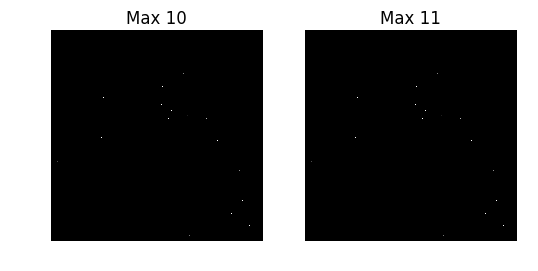

In [161]:
##Compare 2D vs 3D local maxima
plt.subplot(1,2,1),plt.imshow(morphology.binary_dilation(local_max10[4], np.ones((5,5))), cmap='gray')
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Max 10')
plt.subplot(1,2,2),plt.imshow(morphology.binary_dilation(local_max11, np.ones((5,5))), cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Max 11')

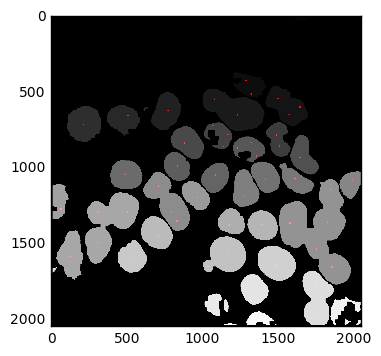

In [111]:
##Check local max using overlay
plt.imshow(mh.overlay(mask6[z], morphology.binary_dilation(local_max10[z], np.ones((9,9)))))

In [112]:
#Test 3D watershed in 2D
markers, n_max = mh.label(local_max10[4])
labels_ws2 = watershed(-distance3D[4], markers, mask=mask6[z])

(<matplotlib.axes._subplots.AxesSubplot at 0x193bfdbe0>,
 <matplotlib.text.Text at 0x193e01898>)

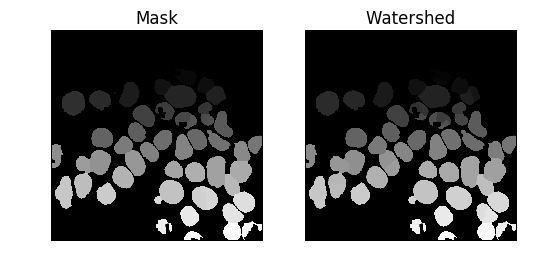

In [114]:
plt.subplot(1,2,1),plt.imshow(labels_ws, cmap='gray')
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Mask')
plt.subplot(1,2,2),plt.imshow(labels_ws2, cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Watershed')

In [ ]:
##Increase the footprint even higher
local_max12 = peak_local_max(distance3D, indices=False, threshold_abs=7, footprint=np.ones((1, 175, 175)), labels=mask6)

In [ ]:
##Check local max using overlay
plt.imshow(mh.overlay(mask6[z], morphology.binary_dilation(local_max12[z], np.ones((9,9)))))

In [172]:
markers, n_max = mh.label(local_max12)

In [174]:
# ##Full 3D
# labels_ws3 = watershed(-distance3D, markers, mask=mask6)
# ##Full 3D sucks!!

In [183]:
for f in range(24):
    ws4[f] = watershed(-distance3D[f], markers[f], mask=mask6[f])

In [181]:
def watershed3D(mask, peaks, distance):

    labels=np.zeros_like(mask)
    
    #Calculate labels in 2D
    for f, frame in enumerate(mask):
            
        labels[f] = watershed(-distance[f], peaks[f], mask=mask[f])
        
    return labels

In [177]:
##Iterative Watershed
ws4 = watershed3D(distance=distance3D, mask=mask6, peaks=local_max12)

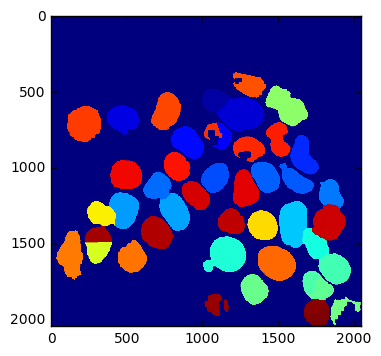

In [184]:
plt.imshow(ws4[4])
#plt.imshow(watershed(-distance3D[4], markers[4], mask=mask6[4]))
#plt.imshow(watershed3D(distance=-distance3D[4], peaks=markers[4], mask=mask6[4]))

In [193]:
##How do you separate distinct labels.
from scipy.ndimage import morphology

##Define the fillObjects 
def splitWatershed(watershed_labels):
    
    ##Add conditional to only separate objects within the right parameters
    
    #Let's do every z slice
    split=np.zeros_like(watershed_labels)
    for z, frame in enumerate(watershed_labels):

        #Could remove on boarders at this point?
        final=np.zeros_like(frame)

        for l in range(frame.max()):
            ll=l+1
            shrunk=morphology.binary_erosion(frame==ll)*ll
            final=final+shrunk
    split[z]=final
    return split

In [200]:
#Try the first 3 frames
split=splitWatershed(ws4)

KeyboardInterrupt: 

In [206]:
from skimage.morphology import disk

radius = 3
selem = disk(radius)

final=np.zeros_like(ws4[4])

for l in range(ws4[4].max()):
    ll=l+1
    shrunk=morphology.binary_erosion(ws4[4]==ll, selem)*ll
    final=final+shrunk

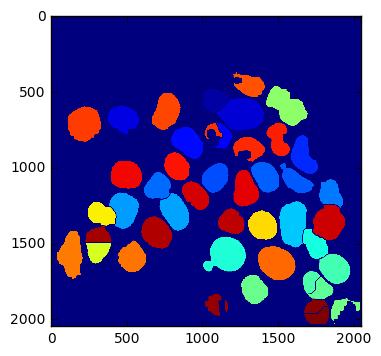

In [207]:
plt.imshow(final)

In [202]:
split=np.zeros_like(ws4)
    for z, frame in enumerate(ws4):

        #Could remove on boarders at this point?
        final=np.zeros_like(frame)

        for l in range(frame.max()):
            ll=l+1
            shrunk=morphology.binary_erosion(frame==ll)*ll
            final=final+shrunk
    split[z]=final

(<matplotlib.axes._subplots.AxesSubplot at 0x1b1938160>,
 <matplotlib.text.Text at 0x1b1c0f780>)

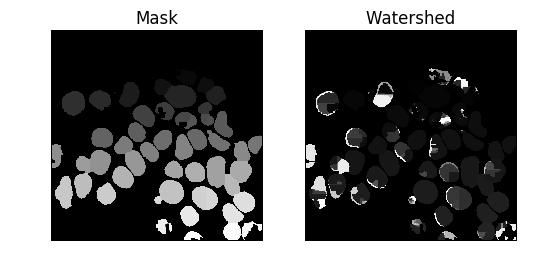

In [117]:
plt.subplot(1,2,1),plt.imshow(labels_ws, cmap='gray')
plt.subplot(1,2,1),plt.axis('off')
plt.subplot(1,2,1),plt.title('Mask')
plt.subplot(1,2,2),plt.imshow(labels_ws3[4], cmap='gray')
plt.subplot(1,2,2),plt.axis('off')
plt.subplot(1,2,2),plt.title('Watershed')

In [68]:
from scipy.ndimage import morphology

##Define the fillObjects 
def fillAndWatershedObjects(labeled_mask):
    
    #Let's do every z slice
    filled_mask=np.zeros_like(labeled_mask)
    for z, frame in enumerate(labeled_mask):

        #Could remove on boarders at this point?
        final=np.zeros_like(frame)

        for l in range(frame.max()):
            ll=l+1
            blob=morphology.binary_dilation(frame==ll, np.ones((20,20)))
            filled_blob=morphology.binary_fill_holes(blob)
            
            ##Don't pass labels forward
            reduced=morphology.binary_erosion(filled_blob, np.ones((20,20)))
            final=final+reduced
        
        #In this script filled mask is binary
        filled_mask[z]=final
        
    #3D Watershed
    split_mask=ws(filled_mask)
        
    return split_mask

(<matplotlib.axes._subplots.AxesSubplot at 0x12a237c88>,
 <matplotlib.text.Text at 0x12a7cad68>)

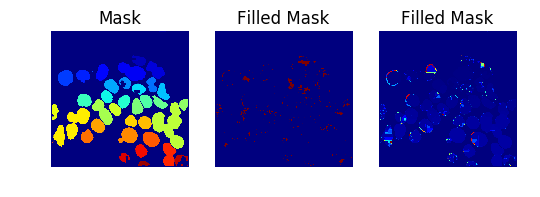

In [29]:
##Compare
plt.subplot(1,3,1),plt.imshow(mask6[z])
plt.subplot(1,3,1),plt.axis('off')
plt.subplot(1,3,1),plt.title('Mask')
plt.subplot(1,3,2),plt.imshow(local_maxi[z])
plt.subplot(1,3,2),plt.axis('off')
plt.subplot(1,3,2),plt.title('Filled Mask')
plt.subplot(1,3,3),plt.imshow(labels_ws[z])
plt.subplot(1,3,3),plt.axis('off')
plt.subplot(1,3,3),plt.title('Filled Mask')

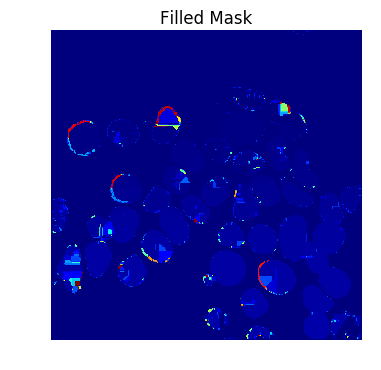

In [27]:
#What?
plt.imshow(labels_ws[z])
plt.axis('off')
plt.title('Filled Mask')

In [67]:
def ws(mask):
    
    from skimage.morphology import watershed
    from skimage.feature import peak_local_max
    from scipy import ndimage

    #This bit is simple
    distance = ndimage.distance_transform_edt(mask)

    #This bit is the challenge   
    local_maxi = peak_local_max(distance, 
                                indices=False,
                                footprint=np.ones((1, 25, 25)),
                                threshold_abs=3,
                                num_peaks=80, 
                                labels=mask)
    
    #Find the centers
    markers = morphology.label(local_maxi)
    
    #Watershed image
    labels_ws = watershed(-distance, markers, mask=mask6)
    
    return labels_ws

In [34]:
new_mask = ws(mask6)

(<matplotlib.axes._subplots.AxesSubplot at 0x12acf1a20>,
 <matplotlib.text.Text at 0xa125b198>)

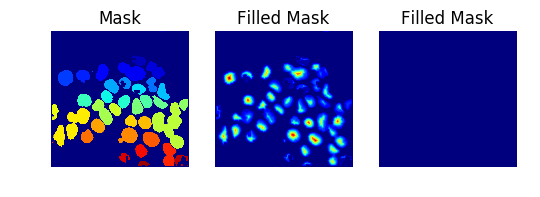

In [37]:
plt.subplot(1,3,1),plt.imshow(mask6[z])
plt.subplot(1,3,1),plt.axis('off')
plt.subplot(1,3,1),plt.title('Mask')
plt.subplot(1,3,2),plt.imshow(distance[z])
plt.subplot(1,3,2),plt.axis('off')
plt.subplot(1,3,2),plt.title('Distance Transform')
plt.subplot(1,3,3),plt.imshow(new_mask[z])
plt.subplot(1,3,3),plt.axis('off')
plt.subplot(1,3,3),plt.title('Filled Mask')

In [59]:
#This bit is the challenge, optimise the footprint

local_maxi_11 = peak_local_max(distance, 
                               threshold_abs=3, #Peak pixels must be more than 3 pixels from the background
                               indices=False, 
                               footprint=np.ones((1, 11, 11)), #A difficult parameter to set
                               labels=mask6,  #I think this will prevent peaks outside of labels
                               num_peaks=80)  #set this to double the number of objects.

#local_maxi_11 = peak_local_max(distance, indices=False, footprint=np.ones((1, 11, 11)), labels=mask6)

(<matplotlib.axes._subplots.AxesSubplot at 0xd4412630>,
 <matplotlib.text.Text at 0xe8ba1400>)

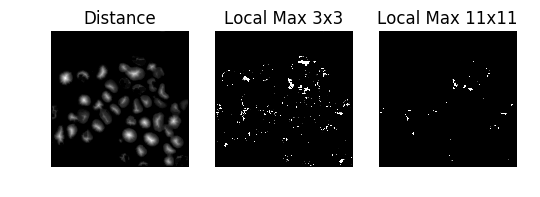

In [61]:
#How appropriate is the local max detection
plt.subplot(1,3,1),plt.imshow(distance[z], cmap='gray')
plt.subplot(1,3,1),plt.axis('off')
plt.subplot(1,3,1),plt.title('Distance')
plt.subplot(1,3,2),plt.imshow(local_maxi[z], cmap='gray')
plt.subplot(1,3,2),plt.axis('off')
plt.subplot(1,3,2),plt.title('Local Max 3x3')
plt.subplot(1,3,3),plt.imshow(local_maxi_11[z], cmap='gray')
plt.subplot(1,3,3),plt.axis('off')
plt.subplot(1,3,3),plt.title('Local Max 11x11')

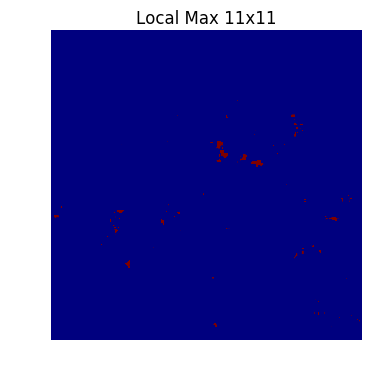

In [62]:
plt.imshow(local_maxi_11[z])
plt.axis('off')
plt.title('Local Max 11x11')

In [65]:
#Find the centers
markers = morphology.label(local_maxi_11)

#Watershed image
labels_ws = watershed(-distance, markers, mask=mask6)

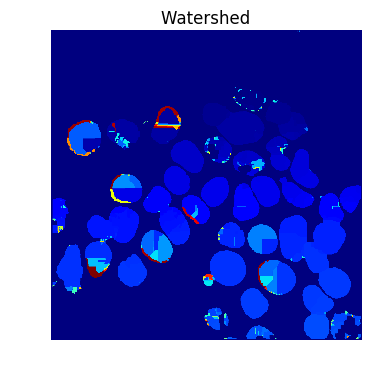

In [66]:
plt.imshow(labels_ws[z])
plt.axis('off')
plt.title('Watershed')

In [69]:
splitMask=fillAndWatershedObjects(mask6)

AttributeError: 'module' object has no attribute 'label'

In [ ]:
plt.imshow(splitMask[z])
plt.axis('off')
plt.title('Watershed')